<a href="https://colab.research.google.com/github/MevrouwHelderder/final_assignment/blob/main/2nd_Try_Final_Assignment_Energy_production_and_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final assignment - Energy production and consumption



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%load_ext google.colab.data_table

In [116]:
path_base = 'https://raw.githubusercontent.com/MevrouwHelderder/final_assignment/main/'

paths = {
    'energy_total' : path_base + 'owid-energy-data.csv',
    'co2_greenhouse' : path_base + 'owid-co2-data.csv',
    'net_zero_pledge' : path_base + 'net-zero-targets.csv',
    'milk_consumption_df': path_base + 'per-capita-milk-consumption.csv',
    'milk_production_df': path_base + 'milk-production-tonnes.csv',
    'meat_supply_df': path_base + 'meat-supply-per-person.csv',
    'meat_production_df': path_base + 'global-meat-production.csv',
    'food_foodprints_df': path_base + 'food-footprints.csv',
    'aviation_per_capita_df': path_base + 'per-capita-domestic-aviation-km.csv'}

dataframes = {}

for key, value in paths.items():
  dataframes[key] = pd.read_csv(value)

energy_total_df = dataframes['energy_total']
co2_greenhouse_df = dataframes['co2_greenhouse']
net_zero_pledge_df = dataframes["net_zero_pledge"]
milk_consumption_df = dataframes['milk_consumption_df']
milk_production_df = dataframes['milk_production_df']
meat_supply_df = dataframes['meat_supply_df']
meat_production_df = dataframes['meat_production_df']
food_foodprints_df = dataframes['food_foodprints_df']
aviation_km_df = dataframes['aviation_per_capita_df']


In [3]:
# Function to create the needed dataframe out of the original
def make_df(original_df, topic_list, base_list, columns_to_keep_list, per_capita=False):
    new_columns = columns_to_keep_list
    base_list = base_list

    for topic_item in topic_list:
        for base_item in base_list:
            new_columns.append(topic_item + base_item)
    
    new_df = original_df[new_columns].copy()

    return new_df


# Fuel use

In [42]:
# singular sources: 
fuel_list = ['coal', 'oil', 'gas', 'wind', 'solar', 'hydro', 'nuclear', 'other_renewables', 'low_carbon', 'fossil']

# lists with columns bases
fuel_share_base_list = ['_share_energy']

# Columnnames that don't need to be pieced together
fuel_complete_columns_list = ['country', 'year', 'iso_code', 'energy_per_capita']

# Note: there does not seem to be a column for the share of energt consumption from other renewables excluding biofuel 
# so for now I will  use the column where biofuel is included and not use the biofuel column seperately.

# Make df
fuel_use = make_df(energy_total_df, fuel_list, fuel_share_base_list, fuel_complete_columns_list, per_capita=False)

# show only the true countries, not the combinations like continents
fuel_use = fuel_use[~fuel_use['iso_code'].isnull()].copy()

# Setting the index
fuel_use = fuel_use.set_index('year')
fuel_use.index = pd.to_datetime(fuel_use.index, format='%Y', errors="coerce")

fuel_use = fuel_use.drop(['iso_code'], axis=1)
fuel_use = fuel_use.dropna()

# Pledges and Targets

In [6]:
# pledge dataframe
net_zero_pledge = net_zero_pledge_df.loc[:,['Entity', 'Year', 'Status of net-zero target']].copy()
net_zero_pledge = net_zero_pledge.rename(columns={'Entity': 'country', 'Year' :'pledged_year', 'Status of net-zero target': 'status'})


# CO2 emission:

In [108]:
co2_df = co2_greenhouse_df.loc[:,['country', 'year', 'iso_code',
                                  'population',	'gdp', 'consumption_co2',	
                                  'consumption_co2_per_capita',
                                  'co2','co2_per_capita' ]]

# show only the true countries, not the combinations like continents
co2_df = co2_df[~co2_df['iso_code'].isnull()].copy()

# Add a column with the gdp per capita to totals
co2_df['gdp_per_capita'] = (co2_df['gdp']/co2_df['population']).round(3)

# Setting the index
co2_df = co2_df.set_index('year')
co2_df.index = pd.to_datetime(co2_df.index, format='%Y', errors="coerce")

# Dropping not needed columns
co2_df = co2_df.drop(['iso_code', 'gdp', 'population'], axis=1)

# Renaming
co2_df = co2_df.rename(columns={'consumption_co2_per_capita': 'total_co2_consumed_per_capita', 
                                'gdp_per_capita': 'gdp_per_capita', 'consumption_co2': 'total_co2_consumed', 
                                'co2': 'total_co2_emitted', 'co2_per_capita': 'total_co2_emitted_per_capita' })



# Food

Let's first look at what foodsources are resonsible for the most greenhouse gas emission. 
In the following table the combined greenhouse gasses are measured in CO2 equivalents. Meaning the are scaled in such a way that their impact is the same as that of CO2.

<Axes: ylabel='Entity'>

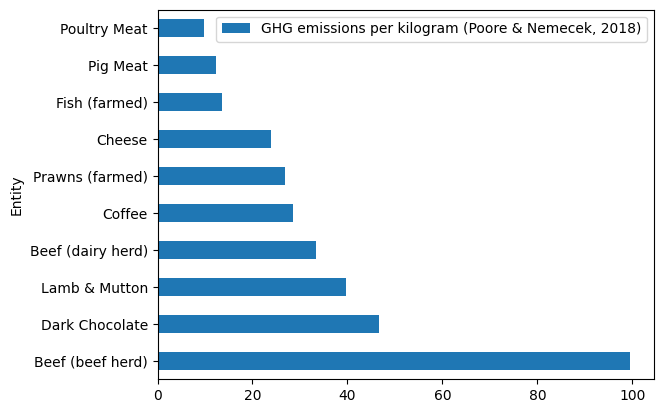

In [8]:
top_ten_food_co2 = food_foodprints_df.sort_values('GHG emissions per kilogram (Poore & Nemecek, 2018)', ascending=False).head(10)
top_ten_food_co2.plot.barh( 'Entity', 'GHG emissions per kilogram (Poore & Nemecek, 2018)')

We can see that most of the food sources with a high carbon foodprint are meat- or dairy products.
The two non-animal products, coffee and dark chocolate, have a high greenhouse gass emission because of the deforestation during the production.
However, both coffee and chocolate have a high emission per kilogram but are usually not eaten in the same quantities as the other products in the top 10.
It is clear that when looking at food as a possible indicator of a high CO2 emission we should look at the animal-based products.

How much of those are being produced and consumed in a country?

In [87]:
consumption = pd.merge(meat_supply_df, milk_consumption_df, on=['Entity', 'Code', 'Year'], how='outer')
consumption = consumption.rename(columns={'Entity': 'country', 'Year': 'year',
                                          'Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita':
                                          'meat_consumption_per_capita_(kg per year)',
                                          'Milk - Excluding Butter | 00002848 || Food available for consumption | 0645pc || kilograms per year per capita':
                                          'dairy_consumption_per_capita_(kg_per_year)'
                                                      })
# Setting the index
consumption = consumption.set_index('year')
consumption.index = pd.to_datetime(consumption.index, format='%Y', errors='coerce')
# show only the true countries, not the combinations like continents
consumption = consumption[~consumption['Code'].isnull()].copy()
consumption = consumption.drop(['Code'], axis=1)

# Transport

In [123]:
transport_co2 = pd.merge(aviation_co2_df, transport_co2_df, on=['Entity', 'Code', 'Year'], how='outer')
transport_co2 = pd.merge(transport_co2, aviation_km_df, on=['Entity', 'Code', 'Year'], how='outer')
transport_co2 = transport_co2.rename(columns={'Entity': 'country', 'Year': 'year', 'Per capita aviation CO2 - adjusted': 'aviation_CO2_per_capita', 
                                              'Transport (per capita)': 'other_transport_CO2_per_capita',
                                              'Per capita domestic RPKs': 'aviation_km_per_capita'})
# show only the true countries, not the combinations like continents
transport_co2 = transport_co2[~transport_co2['Code'].isnull()].copy()

transport_co2 = transport_co2.drop(['Code'], axis=1)
transport_co2 = transport_co2.set_index('year')
transport_co2.index = pd.to_datetime(transport_co2.index, format='%Y', errors='coerce')

transport_food = pd.merge(transport_co2,consumption ,on=['country', 'year'], how='outer')


# Combining it into a dataframe that can be used for comparison

In [203]:
everything = pd.merge(co2_df, transport_food,on=['country', 'year'], how='outer')
everything = pd.merge(everything, fuel_use[['country', 'fossil_share_energy']] ,on=['country', 'year'], how='outer')

# Rows without the co2 consumed per capita present are no use
everything = everything[~everything['total_co2_consumed_per_capita'].isna()]

# Let's look at the last 20 years
everything_2000 = everything[(everything.index.year >= 2000)]

# Function to resample and interpolate
def prepare(df):
    df.index = pd.to_datetime(df.index, format='%Y', errors='coerce')
    df = (
        df.groupby('country')
        .resample("YS")
        .mean(numeric_only=True)
        .interpolate(method='linear')
    )
    df.reset_index(inplace=True)
    df.set_index('year', inplace=True)

    return df


everything_2000_interpolated = prepare(everything_2000).dropna()

# Can I find a correlation between any of the factors and the CO2 output per Capita?

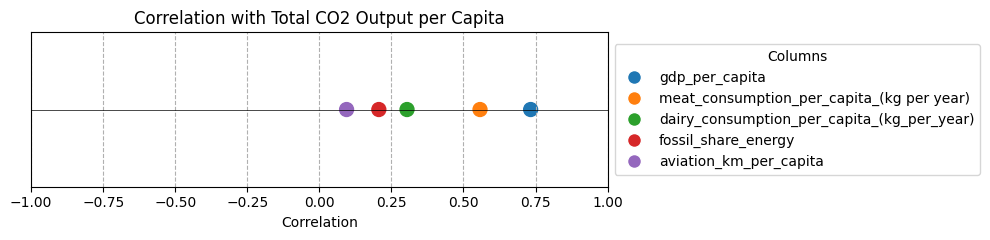

In [173]:
# Calculating correlations
# List of columns to calculate correlations
columns = ['gdp_per_capita', 'meat_consumption_per_capita_(kg per year)',
           'dairy_consumption_per_capita_(kg_per_year)',
           'fossil_share_energy', 'aviation_km_per_capita']

# Initialize a list to store the correlation results
correlation_results_emission = []
p_value_results_emission = []

# Iterate over each column
for column in columns:
    # Calculate the correlation between the column and 'total co2 emitted per capita'
    correlation, p_value = pearsonr(everything_2000_interpolated['total_co2_emitted_per_capita'], everything_2000_interpolated[column])

    # Append the correlation result to the list
    correlation_results_emission.append((column, correlation, p_value))
    p_value_results_emission.append((column, p_value))

# Sort the correlation results by correlation value
correlation_results_emission.sort(key=lambda x: x[1], reverse=True)
p_value_results_emission.sort(key=lambda x: x[1])

# Extract the column names, correlation values, and p-values from the results
columns_emission = [result[0] for result in correlation_results_emission]
correlation_values_emission = [result[1] for result in correlation_results_emission]
p_values_emission = [result[1] for result in p_value_results_emission]

# Create a figure and two subplots
fig,ax = plt.subplots(figsize=(10, 2.5))

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

y_emission = np.zeros(len(columns_emission))

scatter = ax.scatter(correlation_values_emission, y_emission, c=colors, s=100)

ax.tick_params(axis='y', left=False, labelleft=False)
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(axis='x', linestyle='--')
  
ax.set_xlim(-1, 1)
ax.set_title('Correlation with Total CO2 Output per Capita')
ax.set_xlabel('Correlation')

legend_elements1 = [plt.Line2D([0], [0], marker='o', color='w', label=column, markerfacecolor=color, markersize=10) for column, color in zip(columns_consumption, colors)]
legend_elements2 = [plt.Line2D([0], [0], marker='o', color='w', label=column, markerfacecolor=color, markersize=10) for column, color in zip(columns_emission, colors)]
ax.legend(handles=legend_elements1, loc='center left', bbox_to_anchor=(1, 0.5), title='Columns')

plt.tight_layout()
plt.show()

# Conclusion:
* **gdp**: The correlation coefficient of 0.73 indicates a strong positive correlation between GDP per capita and the total energy per capita consumed. This suggests that as GDP per capita increases, there is a tendency for higher energy consumption per capita. The p-value of 0.0 indicates that this correlation is highly statistically significant, providing strong evidence of the relationship.

* **meat_consumption**: The correlation coefficient of 0.56 suggests a moderate positive correlation between meat consumption per capita and the total energy per capita consumed. This implies that higher meat consumption is associated with higher energy consumption. The p-value of 2.34e-202 indicates that this correlation is highly statistically significant.

* **dairy_consumption**: The correlation coefficient of 0.30 indicates a weak positive correlation between dairy consumption per capita and the total energy per capita consumed. This suggests that higher dairy consumption is somewhat associated with higher energy consumption. The p-value of 3.48e-54 suggests that this correlation is statistically significant.

* **fossil energy**: The correlation coefficient of 0.21 indicates a weak positive correlation between the share of fossil energy and the total energy per capita consumed. This implies that a higher share of fossil energy in the energy mix is somewhat associated with higher energy consumption. The p-value of 3.11e-25 suggests that this correlation is statistically significant.

* **aviation**: The correlation coefficient of 0.09 suggests a weak positive correlation between aviation kilometers traveled per capita and the total energy per capita consumed. This indicates that higher levels of aviation activity are somewhat associated with higher energy consumption. The p-value of 2.51e-06 suggests that this correlation is statistically significant.

The biggest predictor of a large CO2 output per capita seems to be the GDP.
Which makes sense. A higher quality of living requires more energy. Bot in the sense of electricity but also when it comes to energy needed for the production of more items and food.

# which countries are making the biggest strides in decreasing CO2 output?

Let's first look the change in CO2 output over the past 20 years. 
It is important to not only look at the total output per capita but also the output per capita that has been corrected for trade.
Because countries that produce for other countries emit CO2 for that other country.
When 


In [292]:
# Finding the top and bottom when it comes to the share of primary that comes from low-carbon
grouped = everything_2000_interpolated.groupby('country')

first_consumption = grouped.first()['total_co2_consumed_per_capita']
last_consumption = grouped.last()['total_co2_consumed_per_capita']
relative_change_consumption = (((last_consumption - first_consumption) / first_consumption)* 100).round(3)

first_gdp = grouped.first()['gdp_per_capita']
last_gdp = grouped.last()['gdp_per_capita']
relative_change_gdp = (((last_gdp - first_gdp) / first_gdp)* 100).round(3)

change_df = pd.DataFrame({'change_CO2_output_per_capita_(%)': relative_change_consumption})
change_df['change_gdp_per_capita_(%)'] = relative_change_gdp
biggest_consumption_changers = relative_change_consumption.sort_values(ascending=True).head(5)
biggest_consumption_changers = biggest_consumption_changers.astype(str) + " %"

print('The countries that showed the biggest decrease in CO2 emission per capita, corrected for trade, since 2020:')
print(biggest_consumption_changers)

The countries that showed the biggest decrease in CO2 emission per capita, corrected for trade, since 2020:
country
Venezuela         -79.809 %
Portugal          -56.617 %
Greece            -46.478 %
United Kingdom    -45.381 %
Finland           -43.131 %
Name: total_co2_consumed_per_capita, dtype: object


We can see that there are countries that managed to decrease their CO2 output per capita.

However, the biggest strides are probably being made by countries that manage to decrease CO2 output per capita while also increasing GDP. 
Because that means that they not only decreased their output but also found a way to counteract  the growth in CO2 emissions due to the rising standard of living.

Let's look at specifically the output per capita and the GDP.

In [371]:
biggest_strides = change_df[(change_df['change_CO2_output_per_capita_(%)'] < 0) & (change_df['change_gdp_per_capita_(%)'] > 0)].copy()
co2_rank = biggest_strides['change_CO2_output_per_capita_(%)'].rank(ascending=True)
gdp_rank = biggest_strides['change_gdp_per_capita_(%)'].rank(ascending=False)
biggest_strides['total_rank'] = (co2_rank + gdp_rank).rank()
biggest_strides

,change_CO2_output_per_capita_(%),change_gdp_per_capita_(%),total_rank
country,,,
Australia,-9.489,9.577,16.0
Czechia,-19.380,113.056,5.5
El Salvador,-2.586,162.328,11.5
Finland,-43.131,10.299,9.5
Israel,-24.964,25.748,11.5
Jamaica,-11.523,266.437,3.0
Jordan,-22.261,35.750,9.5
Poland,-4.169,92.342,13.0
Portugal,-56.617,51.589,1.0


The following countries show a decline in CO2 output per capita (corrected for trade) and a rise in GDP per capita (in order of biggest decrease in CO2 output): 
* Portugal
* United Kingdom	
* Finland	
* Sweden	
* United Arab Emirates	
* Israel	
* Jordan	
* Slovakia
* Czechia
* South Africa	
* Jamaica
* Australia
* Ukraine
* Poland
* El Salvador	
* Zambia

It is also possible to rank them, based on how well they did on both aspects, the top ten would like this: 




In [372]:
biggest_strides['total_rank'].sort_values(ascending=True).head(10)

country
Portugal          1.0
Jamaica           3.0
South Africa      3.0
United Kingdom    3.0
Czechia           5.5
Ukraine           5.5
Slovakia          7.5
Sweden            7.5
Finland           9.5
Jordan            9.5
Name: total_rank, dtype: float64

However, I believe that this would be oversimplified. Yes, these countries managed to decrease CO2 consumption per capita while also increasing the GDP per capita but more is needed to truly make big strides, now and in the future.



# What happens when we also look at any pledges and targets on net-zero emission?
Some countries have set a target or made a pledge to reduce Co2 output, working towards a situation where the amount of greenhouse gasses emitted is as close to zero as possible with any remaning emission re-absorbed by, for example, oceans and forest.

However, not all countries have set the same goals and have used the same criteria. For example, not all countries allow for use of carbon offset (removing CO2 instead of not emitting it) in the calculation of the progress.

It is also important to recognize that a pledge is nothing more or less than a promiss. It needs to be put in law to become something that can not be disregarded or changed on the way.

For this assignment I will not look at the criteria and only look at: 
* does a country have a goal?
* what is the pledged year
* what is the status of the goal


In [382]:
even_bigger_strides = pd.merge(change_df, net_zero_pledge, on='country', how='outer' )
achieved = even_bigger_strides[even_bigger_strides['status']=='Achieved']

There are a few countries that have already achieved their goal: 

In [383]:
achieved

,country,change_CO2_output_per_capita_(%),change_gdp_per_capita_(%),pledged_year,status
9,Benin,89.565,86.586,2000.0,Achieved
16,Cambodia,504.113,55.156,2000.0,Achieved
62,Madagascar,19.136,-7.832,2010.0,Achieved
122,Bhutan,NaN,NaN,2000.0,Achieved
124,Guinea-Bissau,NaN,NaN,2030.0,Achieved
125,Guyana,NaN,NaN,2019.0,Achieved
127,Liberia,NaN,NaN,2000.0,Achieved


Congratulations to them! But since they are either small, faily underdeveloped and/or have no data on GDP or CO2 output I will not include them in my search for the biggest stride.

Let's find countries that have: 
* decreased their CO2 output
* increased their GDP
* set a net-zero goal

In [384]:
the_biggest_strides = even_bigger_strides[(even_bigger_strides['change_CO2_output_per_capita_(%)'] < 0) & (even_bigger_strides['change_gdp_per_capita_(%)'] > 0) & (~even_bigger_strides['status'].isna()) ].copy()
the_biggest_strides

,country,change_CO2_output_per_capita_(%),change_gdp_per_capita_(%),pledged_year,status
2,Australia,-9.489,9.577,2050.0,Pledge
34,Finland,-43.131,10.299,2035.0,In policy document
49,Israel,-24.964,25.748,2050.0,Pledge
85,Portugal,-56.617,51.589,2050.0,In policy document
95,South Africa,-12.372,166.736,2050.0,Pledge
99,Sweden,-38.570,30.274,2045.0,In law
110,Ukraine,-4.223,563.781,2060.0,In policy document
111,United Arab Emirates,-30.213,3.172,2050.0,Pledge
112,United Kingdom,-45.381,35.093,2050.0,In law


Four of these countries have made pledges: 
Three of these countries are one step further, the are in the process of creating laws based on their pledges.

But of the countries not only decreased their CO2 output and increased their GDP but have also put their pledges in law: 
* United Kingdom
* Sweden

And since Sweden has pledged to reach their net-zero goal in 2045 while the UK has pledged 2050 I deem Sweden the big winner of the competiton!

# **Sweden has made the biggest stride when it comes to decreasing CO2 output!**





which non-fossil fuel energy technology will have the best price in the future?



To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.